In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


BASE_DIR = '../input/emnist/'

edf = pd.read_csv(os.path.join(BASE_DIR, 'emnist-balanced-train.csv'))
mdf = pd.read_csv(os.path.join(BASE_DIR, 'emnist-mnist-train.csv'))

In [10]:
mdf.columns = range(len(mdf.columns))
edf.columns = range(len(edf.columns))


edf_categories = edf.groupby([edf.columns[0]])[edf.columns[1]].count()
print('EDF categories: ', len(edf_categories))

mdf.iloc[:, 0] += len(edf_categories)

mdf_categories = mdf.groupby([mdf.columns[0]])[mdf.columns[1]].count()
print('MDF categories: ', len(mdf_categories))


data = pd.concat([mdf, edf])
merged_categories = data.groupby([data.columns[0]])[data.columns[1]].count()
print('Merged categories: ', len(merged_categories))

data = data.sample(frac=1).reset_index(drop=True)

print('Total images: ', len(data)) 

EDF categories:  47
MDF categories:  10
Merged categories:  57
Total images:  172798


In [11]:
def normalize_image(image):
    image = image.reshape((28, 28))
    image = np.rot90(image[::-1], 3)
    return image


clean_data = []
clean_labels = []

for image in data.values:
    img = normalize_image(image[1:])
    img = np.asarray(img).astype('float32') / 255
    
    label = np.asarray(image[0]).astype('float32')
    
    clean_data.append(img)
    clean_labels.append(label)

full_data = np.asarray(clean_data).reshape(len(clean_data), 28, 28, 1)
full_labels = np.asarray(clean_labels)

In [12]:
from tensorflow.keras.utils import to_categorical


train_data = full_data[:100000]
train_labels = to_categorical(full_labels[:100000])

validation_data = full_data[100000:150000]
validation_labels = to_categorical(full_labels[100000:150000])

test_data = full_data[150000:]
test_labels = to_categorical(full_labels[150000:])

48 52 51 4 39 52 37 50 28 17 

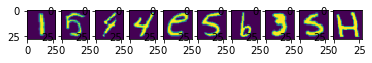

In [13]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(test_data[i].reshape((28, 28)))
    print(np.argmax(test_labels[i]), end=' ')
plt.show()

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers


class Model(tf.keras.models.Model):
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv_1 = layers.SeparableConv2D(32, (3, 3), activation=tf.nn.relu, input_shape=(28, 28, 1))
        self.batch_norm_1 = layers.BatchNormalization(axis=1)
        self.pooling_1 = layers.MaxPooling2D((2, 2))
        
        
        self.conv_2 = layers.SeparableConv2D(64, (3, 3), activation=tf.nn.relu)
        self.pooling_2 = layers.MaxPooling2D((2, 2))

        self.flatten = layers.Flatten()
        self.dropout_1 = layers.Dropout(0.2)
        self.fc = layers.Dense(1024, activation=tf.nn.relu)
        self.fc1 = layers.Dense(512, activation=tf.nn.relu)
        self.fc2 = layers.Dense(256, activation=tf.nn.relu)
        self.fc3 = layers.Dense(len(merged_categories), activation=tf.nn.softmax)
        
        
    def call(self, x):
        x = self.conv_1(x)
        x = self.batch_norm_1(x)
        x = self.pooling_1(x)
        
        x = self.conv_2(x)
        x = self.pooling_2(x)
        
        x = self.flatten(x)
        x = self.dropout_1(x)
        x = self.fc(x)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return self.fc3(x)

    
model = Model()


callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor = 'val_acc',
        patience = 1,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath = 'emnist_model.h5',
        monitor = 'val_loss',
        save_best_only=True,
    )
]

model.compile(
    loss = losses.categorical_crossentropy,
    optimizer = optimizers.Adam(learning_rate=0.001),
    metrics = ['accuracy'],
)

In [15]:
history = model.fit(
    train_data, train_labels,
    validation_data = [validation_data, validation_labels],
    batch_size = 64,
    epochs = 10,
    callbacks = callbacks_list,
)

Train on 100000 samples, validate on 50000 samples
Epoch 1/10
100000/100000 [==============================] - 12s 117us/sample - loss: 0.9768 - accuracy: 0.6615 - val_loss: 0.7205 - val_accuracy: 0.7291
Epoch 2/10
100000/100000 [==============================] - 12s 120us/sample - loss: 0.6838 - accuracy: 0.7378 - val_loss: 0.6610 - val_accuracy: 0.7464
Epoch 3/10
100000/100000 [==============================] - 11s 110us/sample - loss: 0.6220 - accuracy: 0.7550 - val_loss: 0.6457 - val_accuracy: 0.7549
Epoch 4/10
100000/100000 [==============================] - 11s 110us/sample - loss: 0.5819 - accuracy: 0.7658 - val_loss: 0.6395 - val_accuracy: 0.7557
Epoch 5/10
100000/100000 [==============================] - 11s 112us/sample - loss: 0.5531 - accuracy: 0.7737 - val_loss: 0.6315 - val_accuracy: 0.7595
Epoch 6/10
100000/100000 [==============================] - 11s 110us/sample - loss: 0.5282 - accuracy: 0.7809 - val_loss: 0.6485 - val_accuracy: 0.7605
Epoch 7/10
100000/100000 [=====

In [21]:
model.load_weights('emnist_model.h5')

Test accuracy:  75.87 %


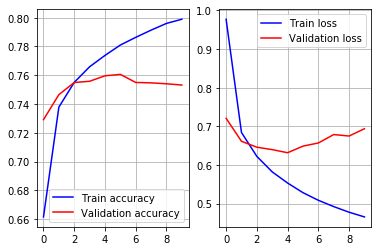

In [22]:
_, accuracy = model.evaluate(test_data, test_labels, verbose=0)
print('Test accuracy: ', round(accuracy * 100, 2), '%')

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'b-', label='Train accuracy')
plt.plot(history.history['val_accuracy'], 'r-', label='Validation accuracy')

plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'b-', label='Train loss')
plt.plot(history.history['val_loss'], 'r-', label='Validation loss')

plt.legend()
plt.grid()
plt.show()

In [17]:
prediction = model.predict(test_data)

Prediction:  52 	 Label:  52


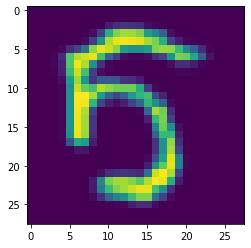

In [18]:
index = 1
print('Prediction: ', np.argmax(prediction[index]), '\t', 'Label: ', np.argmax(test_labels[index]))
plt.imshow(test_data[index].reshape((28, 28)))